In [29]:
import torch
flag = torch.cuda.is_available()
if flag:
    print("CUDA可使用")
else:
    print("CUDA不可用")

ngpu= 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("驱动为：",device)
print("GPU型号： ",torch.cuda.get_device_name(0))

CUDA可使用
驱动为： cuda:0
GPU型号：  GeForce GTX 1050 Ti


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt #数据可视化
import numpy as np 
from PIL import Image
from torchvision import datasets, transforms
from torchsummary import summary #从 torchsummary里导入 summary，打印显示网络结构和参数

In [31]:
batch_size=64
# 将数据集合下载到指定目录下,这里的transform表示，数据加载时所需要做的预处理操作
# 加载训练集合
train_dataset=torchvision.datasets.MNIST(
    root='.data',
    train=True,
    transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Resize(224),    # 缩放图像大小为 224*224  LeNet未加，默认28*28如果不做裁剪就会像LeNet一样稍微麻烦一点
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]),#转化为tensor且数据标准化注意在FC中我们未做数据增强
    download=True)
# 加载测试集合
test_dataset=torchvision.datasets.MNIST(
    root='.data',
    train=False,
    transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Resize(224),    # 缩放图像大小为 224*224  改变符合模型的尺寸就可以套用模板
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]),
    download=True)

train_loader=torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, #一个批次的大小为128张
        shuffle=True  #随机打乱
    
        )

test_loader=torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=True
        )
 

In [32]:
print('len(train_loader)={}'.format(len(train_loader))) 
print('len(test_loader)={}'.format(len(test_loader))) 

len(train_loader)=938
len(test_loader)=157


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


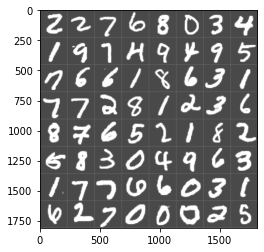

In [33]:
# 展示图像 
# 显示一张图片
def imshow(img):
    img = img / 2 + 0.5      # 逆归一化
    npimg = img.numpy()      # 将张量转换成numpy数组
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose交换维度（0，1，2）转换为（1，2，0） imshow画图
    plt.show()               # 显示图片
    
#
# 得到一些随机训练图像
dataiter = iter(train_loader) # 生成迭代器 
images, labels = dataiter.next()

# 显示图像
imshow(torchvision.utils.make_grid(images))#生成网格

In [34]:
images.shape # 64张图像被迭代器用网格输出1个    64x938 =60000-> 64x937+ 1xa=6000

torch.Size([64, 1, 224, 224])

AlexNet网络的默认的输入图片的尺寸是224*224， 而Mnist数据集的图片的尺寸是28 * 28。
我们在引导数据时候已经做了处理，因而省去了一下麻烦

In [35]:
class AlexNet(nn.Module):
       # 定义构造方法函数，用来实例化
    def __init__(self):
        super(AlexNet, self).__init__()  #  
        self.conv1=nn.Conv2d(in_channels=1,out_channels=96,kernel_size=11,stride=4,padding=1)
        self.conv2=nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,padding=2)
        #接下来连续3分卷积层和较小的卷积窗口
        self.conv3=nn.Conv2d(256,384,kernel_size=3,padding=1)
        self.conv4=nn.Conv2d(384,384,kernel_size=3,padding=1)
        self.conv5=nn.Conv2d(384,256,kernel_size=3,padding=1)
        # FC层
        self.fc1=nn.Linear(6400,4096)
        self.fc2=nn.Linear(4096,4096)
        self.fc3=nn.Linear(4096,10)
        # AlexNet本来是做1000分类的，我们采用迁移学习的思想该为10fc3
    def forward(self, x):                   # 输入shape: torch.Size([1, 1, 224, 224])
        x=F.max_pool2d(F.relu(self.conv1(x)),kernel_size=3,stride=2)
        x=F.max_pool2d(F.relu(self.conv2(x)),kernel_size=3,stride=2)
        x=F.relu(self.conv3(x))
        x=F.relu(self.conv4(x))
        x=F.max_pool2d(F.relu(self.conv5(x)),kernel_size=3,stride=2)
        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x))
        x=F.dropout(x,p=0.5)
        x=F.relu(self.fc2(x))
        x=F.dropout(x,p=0.5)
        x=self.fc3(x)
        return x

In [36]:
model = AlexNet().to(device)
model

AlexNet(
  (conv1): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6400, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
)

In [37]:
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数，一般分类问题都用 one-hot + Cross-entropy 回归问题 用MSE
learning_rate = 0.01 #设置学习率为0.01
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)# 定义 Adam 优化器用于梯度下降 当然也可以用SGD
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum = 0.9)#moentum是动量可以让曲线更加平滑
len(train_loader) # 一共有469个batch

938

In [38]:
def train(epoch):
    run_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):#循环次数batch_idx的最大循环值 +1 = (MNIST数据集样本总数60000/ BATCH_SIZE )
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()#反向计算梯度
        optimizer.step()#优化参数
        run_loss += loss.item()
        if batch_idx % 200 == 199:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, run_loss /200))
            run_loss = 0.0

In [39]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():#此时已经不需要计算梯度，也不会进行反向传播
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) #将数据转移到cuda上
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)# 将输出结果概率最大的作为预测值，找到概率最大的下标,输出最大值的索引位置
            total += labels.size(0)
            correct += (predicted == labels).sum().item()#正确率累加
    print('accuracy on test set: %d %% ' % (100 * correct / total))
    return correct / total

[1,   200] loss: 1.810
[1,   400] loss: 0.196
[1,   600] loss: 0.119
[1,   800] loss: 0.083
accuracy on test set: 98 % 
[2,   200] loss: 0.060
[2,   400] loss: 0.053
[2,   600] loss: 0.047
[2,   800] loss: 0.043
accuracy on test set: 98 % 
[3,   200] loss: 0.036
[3,   400] loss: 0.031
[3,   600] loss: 0.034
[3,   800] loss: 0.034
accuracy on test set: 98 % 
[4,   200] loss: 0.023
[4,   400] loss: 0.030
[4,   600] loss: 0.025
[4,   800] loss: 0.030
accuracy on test set: 99 % 
[5,   200] loss: 0.020
[5,   400] loss: 0.022
[5,   600] loss: 0.025
[5,   800] loss: 0.024
accuracy on test set: 99 % 
[6,   200] loss: 0.016
[6,   400] loss: 0.018
[6,   600] loss: 0.019
[6,   800] loss: 0.019
accuracy on test set: 99 % 
[7,   200] loss: 0.013
[7,   400] loss: 0.014
[7,   600] loss: 0.012
[7,   800] loss: 0.015
accuracy on test set: 99 % 
[8,   200] loss: 0.012
[8,   400] loss: 0.014
[8,   600] loss: 0.012
[8,   800] loss: 0.012
accuracy on test set: 99 % 
[9,   200] loss: 0.010
[9,   400] loss: 

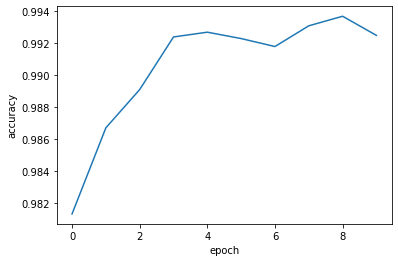

In [40]:
epoch_list = []
acc_list = []
for epoch in range(10):
    train(epoch)
    acc = test()
    epoch_list.append(epoch)
    acc_list.append(acc)
plt.plot(epoch_list, acc_list)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

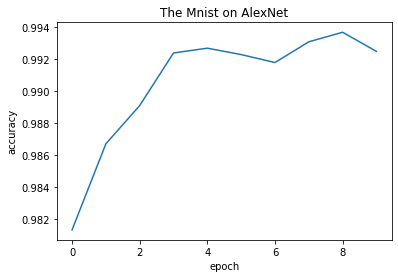

In [41]:
    plt.plot(epoch_list, acc_list)
    plt.title("The Mnist on AlexNet")
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()

In [44]:
acc = np.array(acc_list).mean()
print(f'Accuracy of the network on the 10000 test images: {100*acc} %')
torch.save(model.state_dict(), 'AlexNet1.pth')


Accuracy of the network on the 10000 test images: 99.056 %
